# 基于 DCGAN 生成假的人脸图像

## 1 关于GAN

GAN包括两部分构成

1. 生成器（Generator） - 生成新图像

2. 判别器 （Discriminator）- 基于真实的图像数据集区分真假图像

判别器负责特征提取，将真实图像和生成图像的特征分别映射到真假标签。生成器则相反，生成器是生成图像特征。
GAN模型结构如图1所示。<br/>
<font color ='red'>训练过程中，生成器在生成逼真图像方面逐渐变强，而判别器在辨别这些图像的能力上逐渐变强。当判别器不再能够区分真实图片和伪造图片时，训练过程达到平衡。</font>

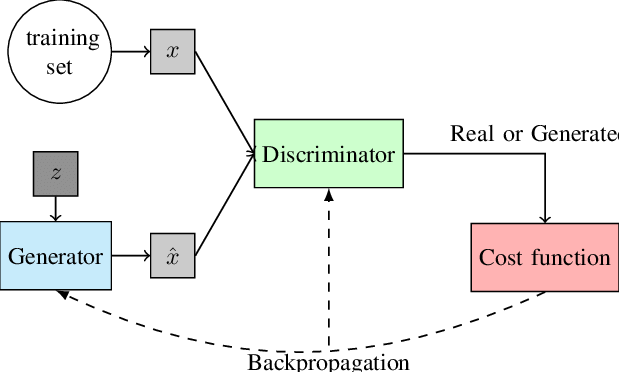
### 图1：GAN模型结构示意

# **GAN的损失函数**

生成器希望下面的损失函数越小越好，判别器希望下面的损失函数越大越好

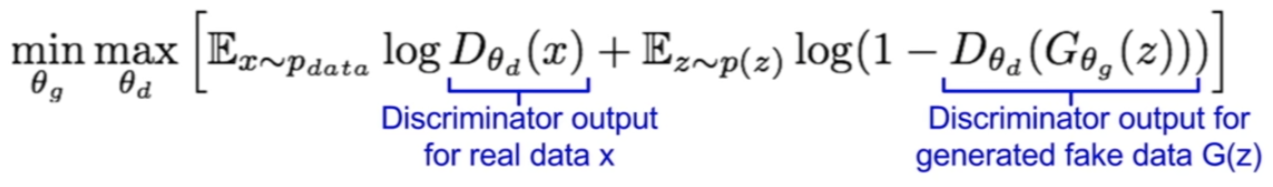

D(x) ：判别器判断真实的x是真实图像的概率值

Ex ：所有真实图像的期望估计值

G(z) ：生成器对噪声图像 z 生成的新图像

D(G(z)) ：判别器估计生成的图像G(z)是真实图像的概率

Ez ：所有输入到生成器中的 z 的期望估计值 (即所有生成的图像 G(z) 的期望估计值)

<font color='red'>生成器不能直接影响到 log(D(x) 的值，所以对于上面的损失函数而言，最小化损失相当于最小化 log(1 - D(G(z)))</font>

## 2 关于DCGAN

【1】生成器用tanh作为激活函数，特征值映射到[-1,1]区间，本实验用sigmoid替换<br/>
【2】权重初始为均值为0，标准差为0.02的正态分布<br/>
【3】LeakyReLU的斜率设置为0.2<br/>
【4】采用Adam优化算法（生成器和判别器）<br/>
【5】学习率设置为2e-4<br/>
【6】momentum的beta1设置为0.5<br/>
<font color='red'>当然，还有结构的变化，用卷积构建网络</font><br/>
#### 生成器网络结构如图2所示。

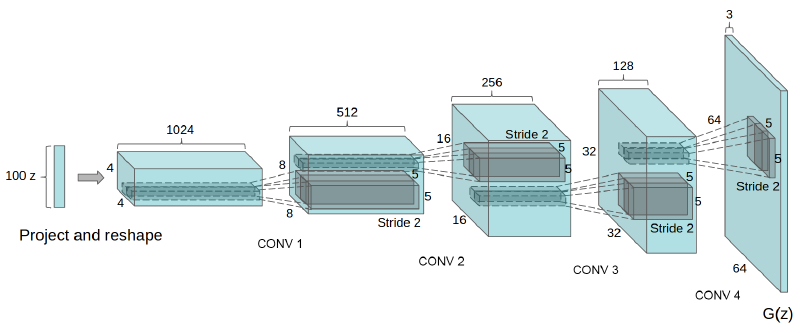
#### 图2 生成器结构

#### 图3显示了生成器与判别器的结构对比，生成器与判别器均为卷积网络，但是卷积过程不同，功能不同。

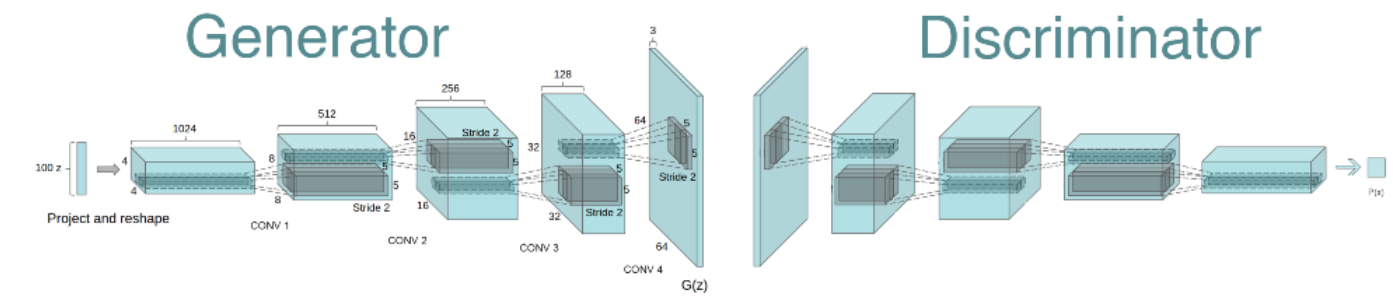
#### 图3 生成器与判别器结构对比

In [ ]:
import numpy as np 
import pandas as pd

from PIL import Image
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from keras import preprocessing
from keras.models import Sequential
from keras.layers import Conv2D,Dropout,Dense,Flatten,Conv2DTranspose,BatchNormalization,LeakyReLU,Reshape


## 3 世界名人数据集预处理

数据集包含20多万幅人脸图像，为了缩减计算规模，可以根据需要选择图像用于模型训练

In [ ]:
path_celeb = []
train_path_celeb = "/kaggle/input/celeba-dataset/img_align_celeba/img_align_celeba/"
for path in os.listdir(train_path_celeb):
    if '.jpg' in path:
        path_celeb.append(os.path.join(train_path_celeb, path))

可以根据计算能力，适当增加图像选取数量

In [ ]:
select_path=path_celeb[0:50000]  # 选取图像

the dataset have more than 202k images of which only 50k are being selected for the training purpose

In [ ]:
%%time
crop = (30, 55, 150, 175) #图像裁剪，使得面部居于图像中心
# 目标图像大小64*64
images = [np.array((Image.open(path).crop(crop)).resize((64,64))) for path in select_path]
for i in range(len(images)):
    images[i] = ((images[i] - images[i].min())/(255 - images[i].min())) # 归一化
    
images = np.array(images) 

上面的图像读取、裁剪，需要费些时间，请耐心等待....

In [ ]:
X_train=images  # 样本特征集

In [ ]:
X_train.shape

#### 样本集观察

In [ ]:
# 从训练集抽取20幅人脸图像，观察
plt.figure(figsize=(10,15))
fig,ax=plt.subplots(3,5)
fig.suptitle("Real Images")
index = 500

for i in range(3):
    for j in range(5):
            ax[i,j].imshow(X_train[index].reshape(64,64,3))           
            index += 500            
plt.tight_layout()
plt.show()

## 4 创建模型
生成器和判别器均使用 Keras Sequential API 定义。

### 4.1 生成器

生成器使用 tf.keras.layers.Conv2DTranspose（上采样）从种子（随机噪声）中生成图像。以一个使用该种子作为输入的 Dense 层开始，然后多次上采样，直至达到所需的 64x64x3 的图像大小。请注意，除了输出层使用tanh之外，其他层均使用 tf.keras.layers.LeakyReLU 作为激活函数。

In [ ]:
noise_shape = 100

In [ ]:
generator=Sequential()
generator.add(Dense(4*4*512,input_shape=[noise_shape]))
generator.add(Reshape([4,4,512]))
generator.add(Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"))
generator.add(LeakyReLU(alpha=0.2))
generator.add(BatchNormalization())
generator.add(Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"))
generator.add(LeakyReLU(alpha=0.2))
generator.add(BatchNormalization())
generator.add(Conv2DTranspose(64, kernel_size=4, strides=2, padding="same"))
generator.add(LeakyReLU(alpha=0.2))
generator.add(BatchNormalization())
generator.add(Conv2DTranspose(3, kernel_size=4, strides=2, padding="same",
                                 activation='sigmoid'))

In [ ]:
# 做完了模型，看看结构是必要的
generator.summary()

### 4.2 判别器

判别器是一个基于 CNN 的图片分类器。

In [ ]:
discriminator=Sequential()
discriminator.add(Conv2D(32, kernel_size=4, strides=2, padding="same",input_shape=[64,64, 3]))
discriminator.add(Conv2D(64, kernel_size=4, strides=2, padding="same"))
discriminator.add(LeakyReLU(0.2)) 
discriminator.add(BatchNormalization())
discriminator.add(Conv2D(128, kernel_size=4, strides=2, padding="same"))
discriminator.add(LeakyReLU(0.2))
discriminator.add(BatchNormalization())
discriminator.add(Conv2D(256, kernel_size=4, strides=2, padding="same"))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Flatten())
discriminator.add(Dropout(0.5))
discriminator.add(Dense(1,activation='sigmoid'))

In [ ]:
discriminator.summary()

判别器模型最终将被训练为对真实图像输出正值，对伪造图像输出负值。当然这是判别器一厢情愿的理想状态。

## 5 定义DCGAN

有了生成器和判别器，将二者整合为一个整体，即为DCGAN

In [ ]:
DCGAN =Sequential([generator,discriminator])

In [ ]:
# 先定义判别器的优化方法和损失函数
discriminator.compile(optimizer='adam',loss='binary_crossentropy')
discriminator.trainable = False   # 根据需要开关

再定义DCGAN的优化方法和损失函数<br/>
事实上就是定义生成器的优化方法和损失函数，并把生成器和判别器关联起来

In [ ]:
DCGAN.compile(optimizer='adam',loss='binary_crossentropy')

你现在看到的DCGAN的结构，只包含两层，分别代表生成器和判别器

In [ ]:
DCGAN.summary()

## 6 训练模型

In [ ]:
epochs = 300  
batch_size = 128
D_loss=[] #判别器损失记录
G_loss=[] #生成器损失记录

训练多少代才合适？代数少了看不出效果，多了时间成本高！

训练循环的逻辑是：生成器收到一个随机种子作为输入。该种子用于生成一个图像。判别器随后被用于对真实图像（选自训练集）和伪造图像（由生成器生成）进行分类。为每一个模型计算损失，并使用梯度更新生成器和判别器。

In [ ]:
with tf.device('/gpu:0'):
    for epoch in range(epochs):   # epoch循环
        print(f"当前进行到Epoch：{epoch+1}")

        # batch 循环
        for i in range(X_train.shape[0]//batch_size):

            if (i)%100 == 0:
                print(f"\t进行到batch： {i} of {len(X_train)//batch_size}")
            # 根据batch_size和噪声向量维度，为生成器准备均匀分布的噪声矩阵
            noise=np.random.uniform(-1,1,size=[batch_size,noise_shape])
            # 生成器批量生成伪造图像
            gen_image = generator.predict_on_batch(noise)  
            # 从训练集中按照batch_size批量取样本
            train_dataset = X_train[i*batch_size:(i+1)*batch_size]
            # 真实样本的标签
            train_label=np.ones(shape=(batch_size,1))  # 真实样本标签为1
            discriminator.trainable = True  # 判别器可训练
            # 判别器基于真实样本训练，返回真实样本损失
            d_loss1 = discriminator.train_on_batch(train_dataset,train_label)

            # 判别器在伪造数据集上训练，返回伪造样本的损失
            train_label=np.zeros(shape=(batch_size,1))  # 伪造样本标签为0
            d_loss2 = discriminator.train_on_batch(gen_image,train_label)

            D_loss.append(d_loss1+d_loss2)    # 这是一个批次训练后，判别器的总损失
            
            # 根据batch_size和噪声向量维度，为生成器准备均匀分布的噪声矩阵
            noise=np.random.uniform(-1,1,size=[batch_size,noise_shape])
            train_label=np.ones(shape=(batch_size,1))  # 此时要设置伪造图片的标签为1
            discriminator.trainable = False  # 此时要设为False，判别器停止训练
            
            # 训练生成器，返回生成器损失
            g_loss = DCGAN.train_on_batch(noise, train_label)
            
            G_loss.append(g_loss)  # 这是一个批次训练后，生成器的总损失


        if epoch % 5 == 0:  # 每隔五代，观察生成器的效果
            samples = 10
            x_fake = generator.predict(np.random.normal(loc=0, scale=1, size=(samples,100)))

            for k in range(samples):
                plt.subplot(2, 5, k+1)  # 2行五列
                plt.imshow(x_fake[k].reshape(64,64,3))
                plt.xticks([])
                plt.yticks([])


            plt.tight_layout()
            plt.show()
        print('Epoch: %d,  Loss: D_real = %.3f, D_fake = %.3f,  G = %.3f' %   (epoch+1, d_loss1, d_loss2, g_loss))        
print('训练完成！')

完成300代训练，需要2小时多一些。

## 7 模型测试

生成100幅人脸图像

In [ ]:
for i in range(5):
    plt.figure(figsize=(7,7))   
    for k in range(20):
            noise=np.random.uniform(-1,1,size=[100,noise_shape])
            new_img=generator.predict(noise)   # 模型生成100幅新图像
            plt.subplot(5, 4, k+1)
            plt.imshow(new_img[k].reshape(64,64,3))  # 只显示前20幅
            plt.xticks([])
            plt.yticks([])
 
    plt.tight_layout()
    plt.show()

## 8 损失函数曲线

GAN的损失函数曲线，不是简单的下降了，而是需要用新眼光区别对待生成器和损失器

In [ ]:
plt.figure(figsize=(10,10))
plt.plot(G_loss,color='red',label='Generator_loss')  # 生成器的损失
plt.plot(D_loss,color='blue',label='Discriminator_loss')  # 判别器的损失
plt.legend()
plt.xlabel('total batches')
plt.ylabel('loss')
plt.title('Model loss per batch')
plt.show()

## 9 模型保存

In [ ]:
model_path ='DCGAN'
DCGAN.save(model_path)

In [ ]:
model = tf.keras.models.load_model('DCGAN')

In [ ]:
noise=np.random.uniform(-1,1,size=[1,noise_shape])
new_img=generator.predict(noise)   # 模型生成1幅新图像
plt.imshow(new_img[0].reshape(64,64,3))
plt.xticks([])
plt.yticks([])

### 参考

https://tensorflow.google.cn/tutorials/generative/dcgan<br/>
https://www.kaggle.com/sayakdasgupta/fake-faces-with-dcgans
